In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import string
import re

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
# load data exclude Columna1
df_news = pd.read_excel('../data/Noticias.xlsx', usecols='B:F')
df_news.shape

(14396, 5)

In [3]:
df_news.head(2)

,Enlaces,Título,info,contenido,Etiqueta
0,https://www.eltiempo.com/agresion-contra-un-op...,Operador de grúa quedó inconsciente tras agres...,El conductor de una moto le lanzó el casco y p...,Las autoridades están buscando al conductor de...,colombia
1,https://www.eltiempo.com/archivo/documento/CMS...,"Usaquén, primera en infracciones por mal parqueo",La localidad ocupa el primer lugar en comparen...,"""Los andenes son para los peatones"", reclama e...",archivo


In [4]:
df_news.describe()

,Enlaces,Título,info,contenido,Etiqueta
count,14396,14378,11483,13738,14396
unique,14396,13851,11412,13202,26
top,https://www.eltiempo.com/agresion-contra-un-op...,Caricaturas,"Si no tuvo tiempo para informarse hoy, aquí un...",Manizales 10:00 p.m. Ya se venden medicamentos...,archivo
freq,1,138,12,238,9187


# Exercise 1
Data exploration

In [5]:
category_counts = df_news['Etiqueta'].value_counts()
print(category_counts[:15])

Etiqueta
archivo                9187
colombia                934
deportes                727
opinion                 532
mundo                   446
cultura                 430
economia                367
justicia                343
bogota                  311
vida                    268
politica                252
tecnosfera              214
salud                   106
historias-el-tiempo      57
mundial                  47
Name: count, dtype: int64


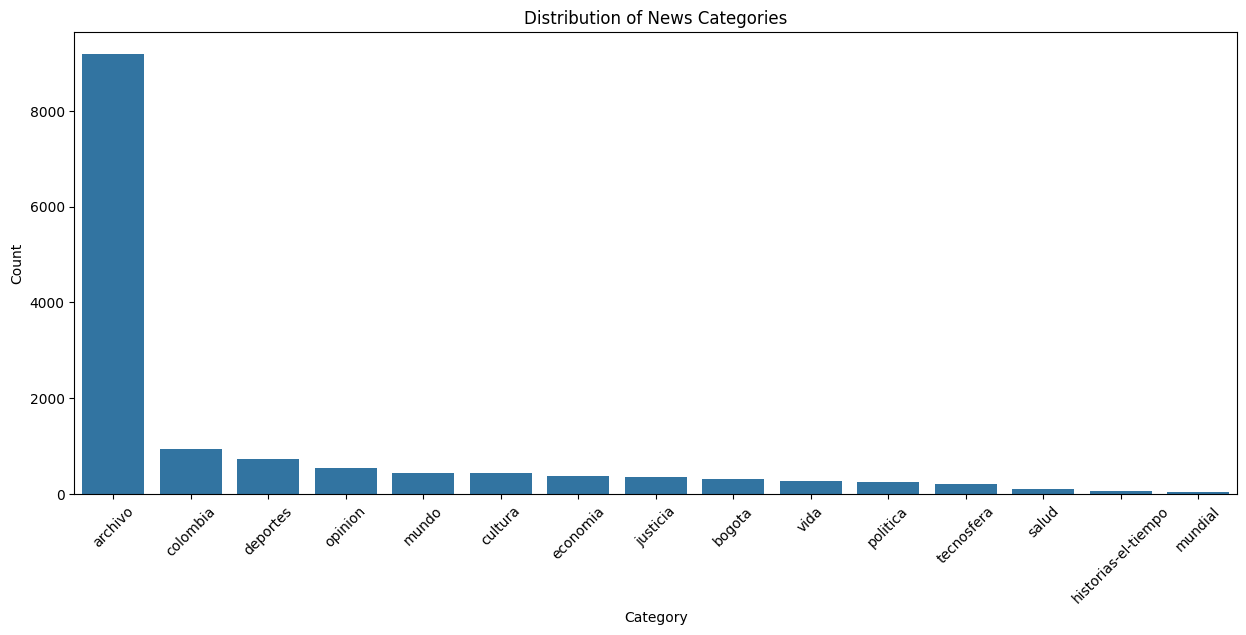

In [6]:
plt.figure(figsize=(15,6))
sns.barplot(x=category_counts.index[:15], y=category_counts.values[:15])
plt.title('Distribution of News Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Exercise 2
Filter by most relevant

In [7]:
# randomly picked 100 as the min threshold
most_relevant_cats = category_counts[(category_counts > 100) & (category_counts < 1000)]
print(most_relevant_cats)

Etiqueta
colombia      934
deportes      727
opinion       532
mundo         446
cultura       430
economia      367
justicia      343
bogota        311
vida          268
politica      252
tecnosfera    214
salud         106
Name: count, dtype: int64


In [8]:
df_filtered = df_news[df_news['Etiqueta'].isin(most_relevant_cats.index)]
df_filtered.shape

(4930, 5)

# Exercise 3
Data preprocessing

In [9]:
df_preprocessed = df_filtered.copy()
df_preprocessed.shape

(4930, 5)

In [10]:
df_preprocessed = df_preprocessed[['Título', 'info', 'contenido', 'Etiqueta']]
df_preprocessed.shape

(4930, 4)

In [11]:
df_preprocessed = df_preprocessed.dropna()
df_preprocessed.shape

(4314, 4)

In [12]:
df_preprocessed.head(2)

,Título,info,contenido,Etiqueta
0,Operador de grúa quedó inconsciente tras agres...,El conductor de una moto le lanzó el casco y p...,Las autoridades están buscando al conductor de...,colombia
9203,Accidente de tránsito en la Autonorte deja men...,Caso se presenta tras 56 días sin siniestros d...,El hecho se presentó el pasado domingo 13 de e...,bogota


In [13]:
df_preprocessed['unified_text'] = 'Título: ' + df_preprocessed['Título'] + '. Resumen: ' + df_preprocessed['info'] + '. Contenido: ' + df_preprocessed['contenido'] + '.'
df_preprocessed.head(2)

,Título,info,contenido,Etiqueta,unified_text
0,Operador de grúa quedó inconsciente tras agres...,El conductor de una moto le lanzó el casco y p...,Las autoridades están buscando al conductor de...,colombia,Título: Operador de grúa quedó inconsciente tr...
9203,Accidente de tránsito en la Autonorte deja men...,Caso se presenta tras 56 días sin siniestros d...,El hecho se presentó el pasado domingo 13 de e...,bogota,Título: Accidente de tránsito en la Autonorte ...


In [14]:
def preprocess_text(text):
    stripped = text.strip()
    cleaned = re.sub(r'[\n\t]+', ' ', stripped)
    cleaned = re.sub(r'\s{2,}', ' ', cleaned)
    cleaned = re.sub(r'\.{2,}', '.', cleaned)
    return cleaned

In [15]:
df_preprocessed['cleaned_text'] = df_preprocessed['unified_text'].apply(preprocess_text)
df_preprocessed.head(2)

,Título,info,contenido,Etiqueta,unified_text,cleaned_text
0,Operador de grúa quedó inconsciente tras agres...,El conductor de una moto le lanzó el casco y p...,Las autoridades están buscando al conductor de...,colombia,Título: Operador de grúa quedó inconsciente tr...,Título: Operador de grúa quedó inconsciente tr...
9203,Accidente de tránsito en la Autonorte deja men...,Caso se presenta tras 56 días sin siniestros d...,El hecho se presentó el pasado domingo 13 de e...,bogota,Título: Accidente de tránsito en la Autonorte ...,Título: Accidente de tránsito en la Autonorte ...


In [16]:
# oov token is used to replace the words which are not in the vocabulary (Out Of Vocabulary)
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df_preprocessed['cleaned_text'])
word_index = tokenizer.word_index
print('Number of unique words:', len(word_index))
print('First 10 words:', dict(list(word_index.items())[:10]))

Number of unique words: 90534
First 10 words: {'<OOV>': 1, 'de': 2, 'la': 3, 'en': 4, 'el': 5, 'que': 6, 'y': 7, 'a': 8, 'del': 9, 'los': 10}


In [17]:
sequences = tokenizer.texts_to_sequences(df_preprocessed['cleaned_text'])
max_length = max([len(seq) for seq in sequences])
X = pad_sequences(sequences, maxlen=max_length, padding='post')
cats = df_preprocessed['Etiqueta'].astype('category').cat
y = cats.codes.values
encoded_category = dict(enumerate(cats.categories))

# Exercise 4
Data split

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Training set size:", X_train.shape, y_train.shape)
print("Validation set size:", X_val.shape, y_val.shape)

Training set size: (3451, 5824) (3451,)
Validation set size: (863, 5824) (863,)


# Exercise 5
RNN model

In [19]:
num_classes = len(encoded_category)
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)

model_rnn = Sequential()
model_rnn.add(Embedding(
    input_dim=len(word_index) + 1,
    output_dim=100,
    input_length=max_length
))
model_rnn.add(SimpleRNN(64))
model_rnn.add(Dense(num_classes, activation='softmax'))

model_rnn.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model_rnn.summary()

/Users/sero/Documents/datascience_master/nat_language/workdir/ean_nlp_projects/.venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-12-06 17:42:07.051195: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-12-06 17:42:07.051334: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-12-06 17:42:07.051346: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-12-06 17:42:07.051381: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-06 17:42:07.051521: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical Pluggable

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
history_rnn = model_rnn.fit(
    X_train,
    y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=20,
    batch_size=1024,
    verbose=1
)

Epoch 1/20


2024-12-06 17:44:40.955798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

### Store model

# Exercise 6
LSTM model

In [ ]:

model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=len(word_index)+1, output_dim=100, input_length=max_length))
model_lstm.add(LSTM(64))
model_lstm.add(Dense(num_classes, activation='softmax'))

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

history_lstm = model_lstm.fit(X_train, y_train_cat,
                              validation_data=(X_val, y_val_cat),
                              epochs=5, batch_size=32)

### Store model

# Exercise 7
Models evaluation

In [ ]:
y_val_pred_rnn = model_rnn.predict(X_val)
y_val_pred_rnn_classes = y_val_pred_rnn.argmax(axis=1)

# LSTM predictions
y_val_pred_lstm = model_lstm.predict(X_val)
y_val_pred_lstm_classes = y_val_pred_lstm.argmax(axis=1)

print("RNN Classification Report:")
print(classification_report(y_val, y_val_pred_rnn_classes, target_names=category_to_int.values()))

print("LSTM Classification Report:")
print(classification_report(y_val, y_val_pred_lstm_classes, target_names=category_to_int.values()))

# Plot accuracy curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['accuracy'], label='RNN Train')
plt.plot(history_rnn.history['val_accuracy'], label='RNN Val')
plt.title('RNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['accuracy'], label='LSTM Train')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM Val')
plt.title('LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()